Basic draftsim analysis (by Arseny Khakhalin and Bobby Mills)

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from Arseny.draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [4]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'M19'

In [5]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [6]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [7]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
1559676,M19,"Leonin_Warleader,Take_Vengeance,Shield_Mare,Ma...","Goreclaw,_Terror_of_Qal_Sisma,Gravedigger,Ghir...","Death_Baron,Plague_Mare,Switcheroo,Macabre_Wal...","Luminous_Bonds,Departed_Deckhand,Skilled_Anima...","Vivien's_Invocation,Gravedigger,Druid_of_the_C...","Ajani's_Last_Stand,Knightly_Valor,Arcane_Encyc...","Murder,Aven_Wind_Mage,Psychic_Symbiont,Walking...","Dark-Dweller_Oracle,Rabid_Bite,Ghastbark_Twins..."
1559677,M19,"Sai,_Master_Thopterist,Snapping_Drake,Skyscann...","Vine_Mare,Lightning_Strike,Bristling_Boar,Plag...","Resplendent_Angel,Angel_of_the_Dawn,Angel_of_t...","Star-Crowned_Stag,Angel_of_the_Dawn,Lich's_Car...","Spit_Flame,Guttersnipe,Electrify,Goblin_Instig...","Sift,Electrify,Switcheroo,Suspicious_Bookcase,...","Bone_Dragon,Vampire_Neonate,Ravenous_Harpy,Sky...","Lathliss,_Dragon_Queen,Lich's_Caress,Trumpet_B..."
1559678,M19,"Valiant_Knight,Murder,Skymarch_Bloodletter,Peg...","Spit_Flame,Electrify,Shock,Rabid_Bite,Draconic...","Spit_Flame,Reassembling_Skeleton,Departed_Deck...","Goblin_Trashmaster,Dwindle,Hostile_Minotaur,Bo...","Open_the_Graves,Gallant_Cavalry,Poison-Tip_Arc...","Goreclaw,_Terror_of_Qal_Sisma,Oakenform,Aviati...","Ajani's_Pridemate,Electrify,Dragon_Egg,Arcane_...","Prodigious_Growth,Skyrider_Patrol,Meteor_Golem..."
1559680,M19,"Hieromancer's_Cage,Leonin_Vanguard,Luminous_Bo...","Ajani,_Adversary_of_Tyrants,Vivien's_Invocatio...","Demon_of_Catastrophes,Lightning_Strike,Skymarc...","Plague_Mare,Shock,Reassembling_Skeleton,Maraud...","Chromium,_the_Mutable,Militia_Bugler,Aethershi...","Hieromancer's_Cage,Heroic_Reinforcements,Aeria...","Departed_Deckhand,Lich's_Caress,Reassembling_S...","Lathliss,_Dragon_Queen,Electrify,Fiery_Finish,..."
1559682,M19,"Tezzeret,_Artifice_Master,Skilled_Animator,Lum...","Djinn_of_Wishes,Angel_of_the_Dawn,Aven_Wind_Ma...","Sarkhan's_Unsealing,Star-Crowned_Stag,Heroic_R...","Meteor_Golem,Luminous_Bonds,Fell_Specter,Rabid...","Demanding_Dragon,Pegasus_Courser,Arcane_Encycl...","Isareth_the_Awakener,Departed_Deckhand,Dwindle...","Goreclaw,_Terror_of_Qal_Sisma,Plague_Mare,Ghas...","Prodigious_Growth,Dryad_Greenseeker,Gargoyle_S..."


In [8]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [9]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guilds = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [10]:
draftCount = 0
player = 'human' # normally should be: "human", but can also be "bot1" or any other bot
ticTime = time.time()
for pile in draftData[player]:#[0:500]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise
            
    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)
    if color1>1 and color2>1:            # Let's pretend that artifact-only and gold-only decks don't exist
        guilds[color1-2][color2-2] += 1

print("Time elapsed: ", time.time() - ticTime)
print("Total drafts analyzed: ", draftCount)

Time elapsed:  231.42323660850525
Total drafts analyzed:  48137


In [11]:
pairs = np.array(pairs)
freq = np.array(freq)
guilds = np.array(guilds)
# plt.imshow(pairs, cmap="Greys")

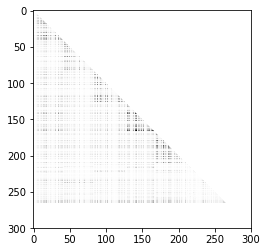

In [12]:
plt.imshow(pairs, cmap="Greys");

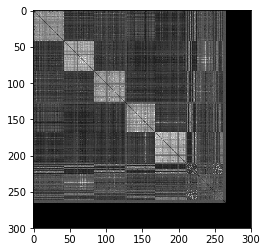

In [13]:
nDrafts = draftCount
prob = pairs*1.0 # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]>0 and freq[j]>0:
            prob[i,j] = prob[i,j]/float(freq[i])/float(freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys");

In [14]:
# Debugging: a list of cards that weren't drafted, but are in the db
for i in range(nCards):
    if freq[i]==0:
        print(cardlist[i])
        del cardpicks[cardlist[i]] # Remove undrafted cards from the dictionary

nicol_bolas_the_arisen
ajani_wise_counselor
ajani's_influence
court_cleric
serra's_guardian
silverbeak_griffin
tezzeret_cruel_machinist
riddlemaster_sphinx
pendulum_of_patterns
tezzeret's_gatebreaker
tezzeret's_strider
liliana_the_necromancer
arisen_gorgon
gravewaker
liliana's_spoils
tattered_mummy
sarkhan_dragonsoul
kargan_dragonrider
sarkhan's_dragonfire
sarkhan's_whelp
shivan_dragon
vivien_of_the_arkbow
aggressive_mammoth
skalla_wolf
ursine_champion
vivien's_jaguar
nexus_of_fate
sun_sentinel
air_elemental
befuddle
mist-cloaked_herald
waterknot
grasping_scoundrel
radiating_lightning
llanowar_elves


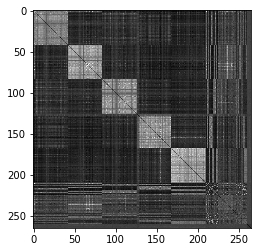

In [15]:
# Remove missing cards from other arrays
# (I make copies of both arrays for some reason, just in case)

dist2 = dist.copy()
dist2 = dist2[freq>0,:]
dist2 = dist2[:,freq>0] # For some reason if I try to subset both rows and columns together, it outputs something stupid
plt.imshow(dist2, cmap="Greys");

freq2 = freq[freq>0]

In [27]:
embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.0001)
fit = embedding.fit_transform(dist2)

In [28]:
df = pd.DataFrame({
        'avg'   : [np.mean(cardpicks[card]) for card in cardpicks],
        'var'   : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq2[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
aegis_of_the_heavens,10.736695,8.057654,1071,W,uncommon,0,-0.342169,0.049035,3346
aethershield_artificer,4.646850,5.960467,1127,W,uncommon,0,0.024234,-0.349199,2802
ajani_adversary_of_tyrants,1.000000,0.000000,442,W,mythic,1,-0.395032,0.132055,1318
ajani's_last_stand,1.252809,0.284402,356,W,rare,0,-0.474601,0.001962,1235
ajani's_pridemate,1.812968,0.670755,1203,W,uncommon,0,-0.578348,-0.160095,3477


In [29]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('Arseny/basic_data_'+setName+'.csv', index_label="name")
np.savetxt('Arseny/distances_'+setName+'.csv', dist, delimiter=",")

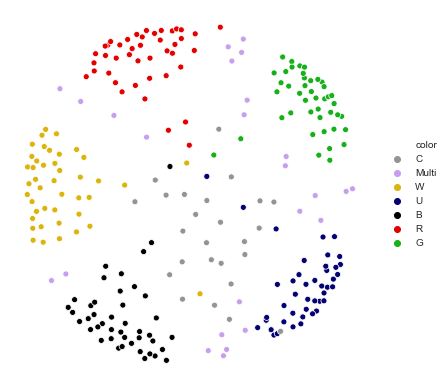

In [30]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(7,6)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

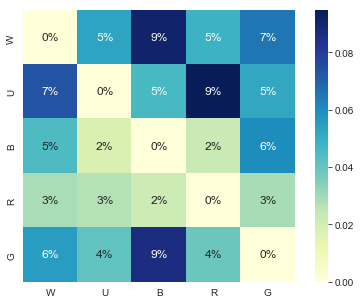

In [23]:
ax = sns.heatmap(guilds/np.sum(guilds), annot=True, fmt="2.0%", cmap="YlGnBu", annot_kws={"size": 12})
ax.set_aspect('equal')
ax.figure.set_size_inches(7,5)
ax.set_xticklabels(["W","U","B","R","G"]); # suppress output, or it returns something
ax.set_yticklabels(["W","U","B","R","G"]); 

In [24]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
jaya's_immolating_inferno,1.0,0.0,287,R,rare,1,0.542684,-0.035042,720
siege-gang_commander,1.0,0.0,711,R,rare,0,0.548138,-0.259492,1619
torgaar_famine_incarnate,1.0,0.0,722,B,rare,1,-0.564399,-0.000215,2162
naru_meha_master_wizard,1.0,0.0,459,U,mythic,1,0.531136,0.349799,1332
verix_bladewing,1.0,0.0,519,R,mythic,1,0.510942,-0.020801,1313
multani_yavimaya's_avatar,1.0,0.0,518,G,mythic,1,-0.273735,0.518503,1462
steel_leaf_champion,1.0,0.0,651,G,rare,0,-0.325002,0.533137,1628
territorial_allosaurus,1.0,0.0,721,G,rare,0,-0.319879,0.467101,1983
yawgmoth's_vile_offering,1.0,0.0,582,B,rare,1,-0.477224,-0.063931,1563
lyra_dawnbringer,1.0,0.0,609,W,mythic,1,-0.028567,-0.449003,1717


In [25]:
# Top controversial cards (without correction for 'intrinsic controversy')
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
the_antiquities_war,8.430676,18.791988,2308,U,rare,0,0.186434,0.280030,6197
lich's_mastery,8.631320,18.772081,1424,B,rare,1,-0.302211,-0.147490,4174
primevals'_glorious_rebirth,8.331280,18.693571,2110,Multi,rare,1,-0.316196,-0.394813,4706
the_mending_of_dominaria,8.034586,17.236398,2660,G,rare,0,-0.237398,0.280675,7743
rona_disciple_of_gix,8.062534,16.848012,3694,Multi,uncommon,1,-0.024291,0.434742,11403
cabal_stronghold,10.023529,16.278313,2295,B,rare,0,-0.286065,-0.049237,6082
haphazard_bombardment,8.577093,15.849784,908,R,rare,0,0.364843,-0.073059,2577
sulfur_falls,9.353173,15.442446,2285,Multi,rare,0,0.431374,0.143729,5422
isolated_chapel,8.466383,15.047165,2112,Multi,rare,0,-0.315304,-0.422810,4756
jhoira_weatherlight_captain,4.904412,14.917333,1632,Multi,mythic,1,0.501044,0.181715,4208
